## **Data Ingestion**

In [1]:
import sys
sys.path.append('../')
!pwd

/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes


In [2]:
import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re
from helpers import *

In [3]:
def get_file_paths(directory_path):
    path_list = []
    for root, directories, files in os.walk(directory_path):
        for file in files:
            # Different workflow needed for Amir next time
            if file != "logs_nome_amir.json":
                path = os.path.join(root, file)
                path_list.append(path)
    return path_list

liam_vlad_dir = (os.getcwd() + '/data3') # Note: Sundial did not work
liam_vlad = get_file_paths(liam_vlad_dir)
all_paths = [path.replace("\\", "/") for path in liam_vlad]

print("File Paths:")
for path in all_paths:
    print(path)

File Paths:
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/logs_nome_vlad.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/logs_nome_liam.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/jason_logs/logs_1690309347726.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/jason_logs/logs_1690309484624.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/jason_logs/logs_1690309994628.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/jason_logs/logs_1690310072237.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/data3/jason_logs/logs_1690310143350.json
/Users/vladimirrife/Desktop/Everything/work/ARLIS/odni/incubator-flagon-distill/prototypes/dat

In [4]:
def combine_json_to_dataframe(file_paths):
    data_list = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            data_list.append(data)

    combined_data = pd.concat([pd.DataFrame(data) for data in data_list], ignore_index=True)
    return combined_data

df = combine_json_to_dataframe(all_paths)
# df = pd.read_json("data3/logs_nome_vlad.json")
df.head()

,target,path,pageUrl,pageTitle,pageReferrer,browser,clientTime,microTime,location,scrnRes,type,logType,userAction,details,userId,toolVersion,toolName,useraleVersion,sessionID
0,path.[object SVGAnimatedString],"[path.[object SVGAnimatedString], g.[object SV...",https://nome.vgihub.geointservices.io/#map=17/...,MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'chrome', 'version': '114.0.0'}",1688069798109,0.8,"{'x': 491, 'y': 682}","{'width': 1156, 'height': 872}",click,raw,True,"{'clicks': 1, 'ctrl': False, 'alt': False, 'sh...",nobody,None,test_app,2.3.0,session_1688066755015
1,None,None,NaN,NaN,NaN,NaN,1688069798116,0.3,None,NaN,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1.1, 'newZoomFactor': 1.1, '...",nobody,None,None,None,session_1688066755015
2,None,None,NaN,NaN,NaN,NaN,1688069798119,0.9,None,NaN,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1.1, 'newZoomFactor': 1.1, '...",nobody,None,None,None,session_1688066755015
3,None,None,NaN,NaN,NaN,NaN,1688069798135,0.3,None,NaN,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1.1, 'newZoomFactor': 1.1, '...",nobody,None,None,None,session_1688066755015
4,NaN,NaN,https://nome.vgihub.geointservices.io/way/1505...,MapEdit,https://nome.vgihub.geointservices.io/,"{'browser': 'chrome', 'version': '114.0.0'}",1688069798093,NaN,NaN,"{'width': 1156, 'height': 872}",viewChange,custom,True,"{'zoom': '17', 'latitude': '39.28386', 'longit...",nobody,None,test_app,2.3.0,session_1688066755015


## Graph Processing/Display

Current visit name graph code

In [5]:
def convert_time(date_type, client_time):
    if date_type == "integer":
        return distill.epoch_to_datetime(client_time)
    elif date_type == "datetime":
        return pd.to_datetime(client_time, unit='ms', origin='unix')
    else:
        return client_time
    
def get_partition(name, partition_elements):
    if name in set(partition_elements):
        return name
    else:
        return "Other"
    print("uh oh")
    return "uh oh"

def get_color_graph(seq, color_dict, partition_func):
    targets = []
    partition_dict = {}
    label_dict = {}
    for name in seq:
        # Append this name to targets
        targets.append(''.join(name))
        # {this name : partition type (blue, red, etc.)}
        partition_dict[targets[-1]] = partition_func(name, color_dict.keys())
        # {this name : name's label"} ??
        label_dict[targets[-1]] = name
        
    # Make a pairwise list of the logs' paths as edges
    edges = list(nx.utils.pairwise(targets))

    # x and y are the nodes connected by the edge, and v is the capacity/direction of the edge
    graph = nx.DiGraph((x, y, {'capacity': v}) for (x, y), v in collections.Counter(edges).items())
    # Sets partition and label attributes for each node in the graph
    nx.set_node_attributes(graph, partition_dict, "partition")
    nx.set_node_attributes(graph, label_dict, "label")
    # Sets node values according to the partition of the node's name
    colors = [color_dict[p] for p in nx.get_node_attributes(graph, "partition").values()]
    # Returns a tuple containing the constructed graph (graph) and the list of colors (colors)
    return (graph, colors)

def setup(file, date_type):
    with open(file, 'r', encoding='utf-8') as json_file:
        raw_data = json.load(json_file)

    # Data = {sessionID : {logUUID : log}}
    data = {}
    curr_sess = {}
    curr_id = next(iter(raw_data))['sessionID']
    # For each log of type 'visit' or 'click', attach it to the log's uuid in the curr_sess dictionary
    for log in raw_data:
        if 'type' in log and (log['type'] == 'visit') and ('name' in log['details']):
            # If the sessionID is different from before, attach the sorted curr_sess dictionary to the curr_id in data
            # and reset it
            if log['sessionID'] != curr_id:
                data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
                curr_id = log['sessionID']
                curr_sess = {}
            # Convert clientTime to specified type and add it to the current session dictionary
            client_time = log['clientTime']
            log['clientTime'] = convert_time(date_type, client_time)
            curr_sess[distill.getUUID(log)] = log
    # Add the final session's dict to the data dict
    data[curr_id] = dict(sorted(curr_sess.items(), key=lambda kv: kv[1]['clientTime']))
    
    return data

Baltimore Workflow 4 (vlad's) graphs:

/var/folders/s4/2b2c8p056l14kw7q9nzs7g1w0000gn/T/ipykernel_50337/1640315216.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


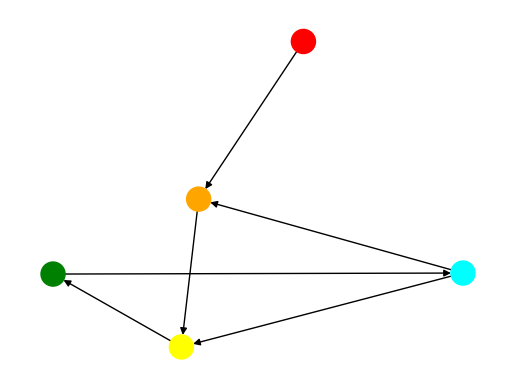

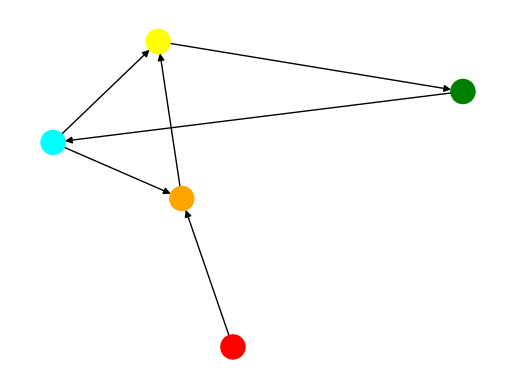

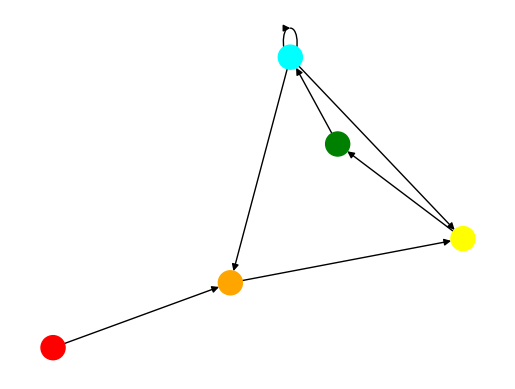

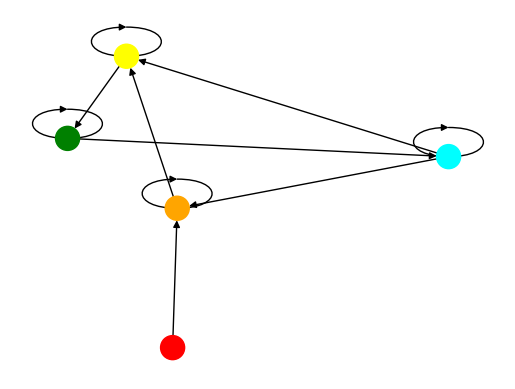

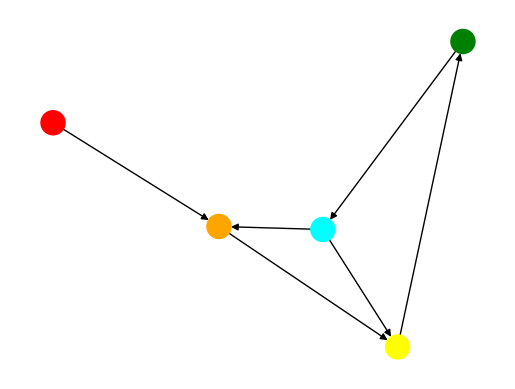

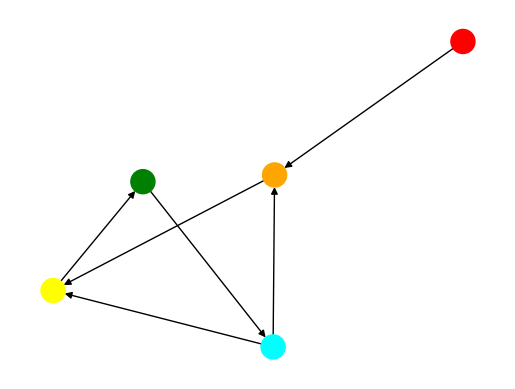

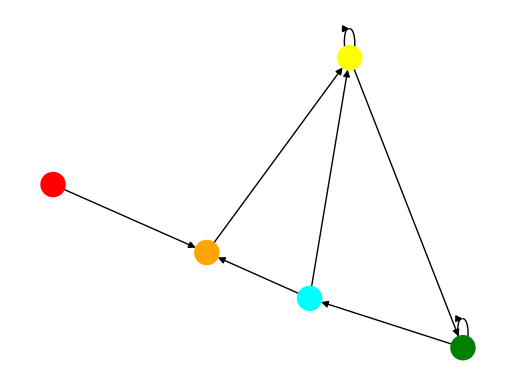

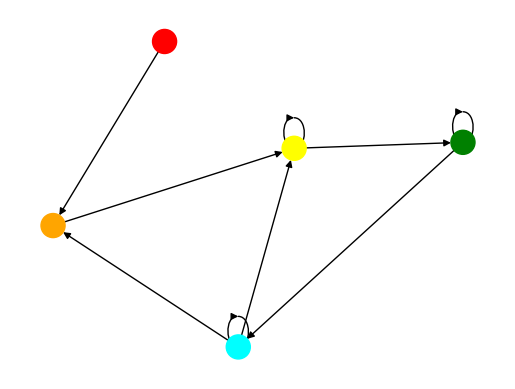

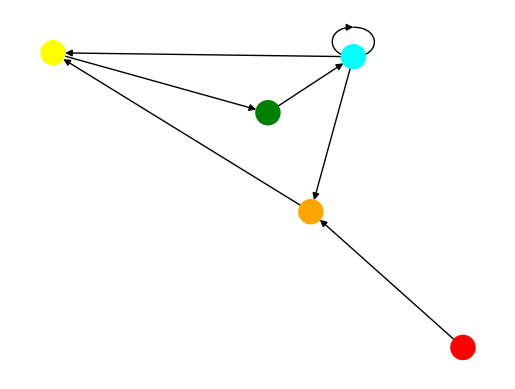

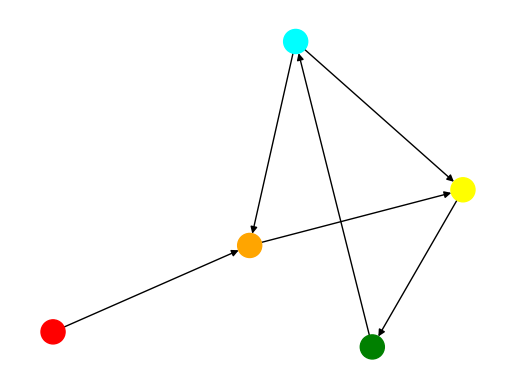

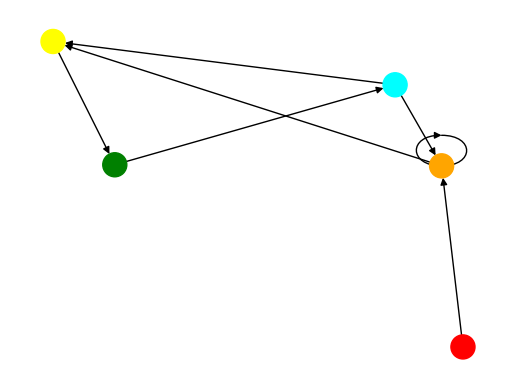

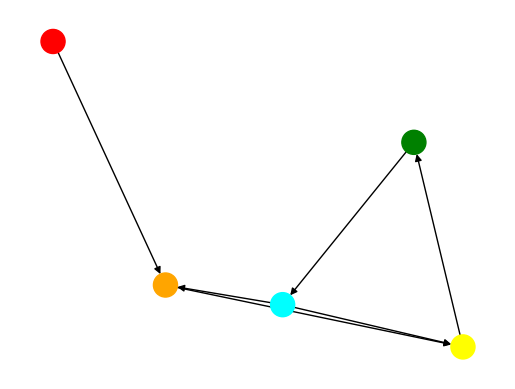

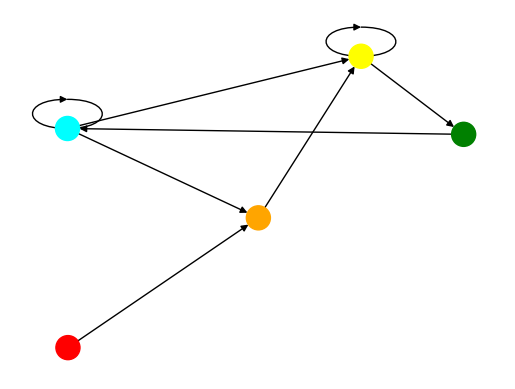

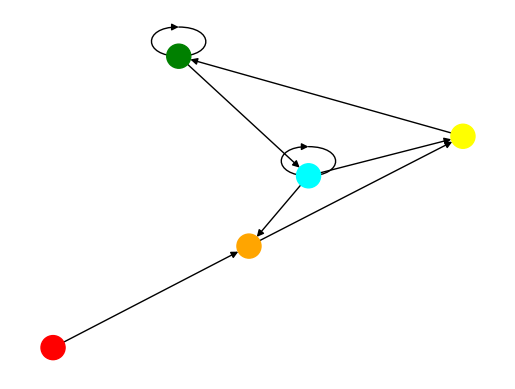

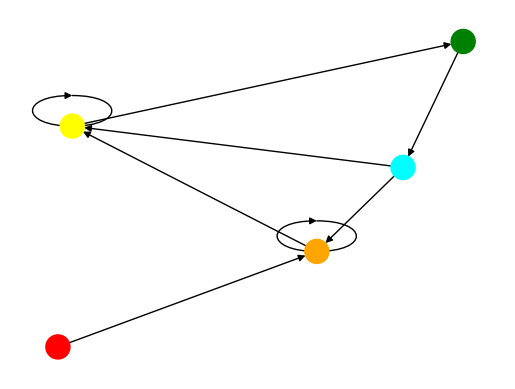

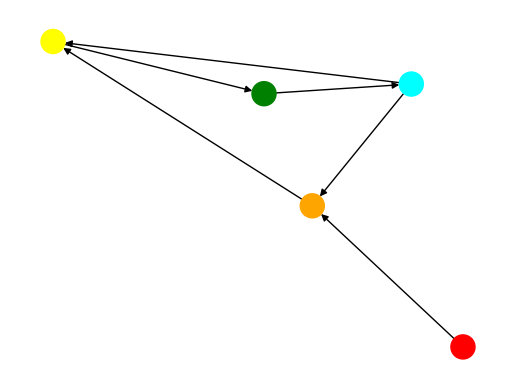

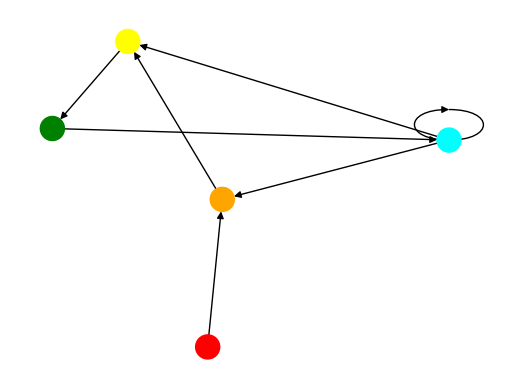

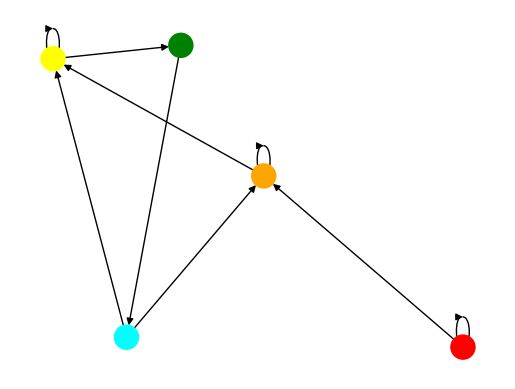

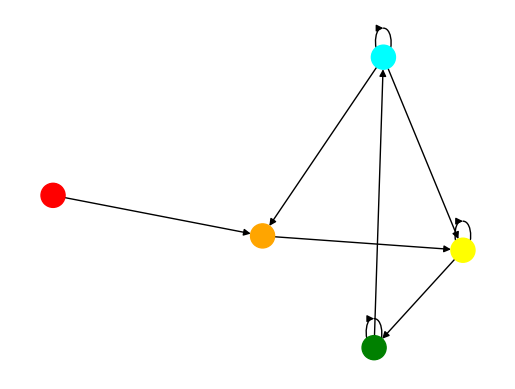

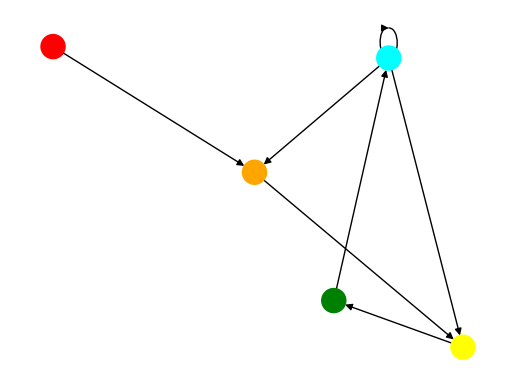

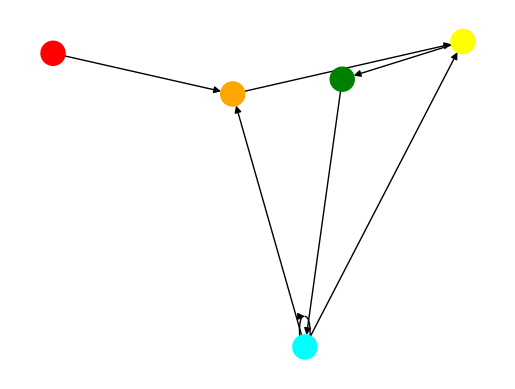

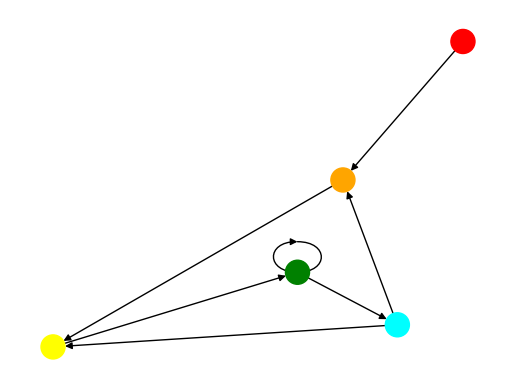

In [6]:
# Path to the logs
# files = ["data3/logs_nome_vlad.json"]
files = all_paths

# Color coding the different elements for the Sankey and Directed graphs
# color_dict = {'Other':'green', 'div.leaflet-pane leaflet-map-pane':'red'}
vlad_color_dict = {'Maryland Science Center and Planetarium':'red', 
              'USS Constellation':'orange', 'World Trade Center':'yellow', 
              'National Aquarium':'green', 'USCGC Taney':'cyan', 
              'Pratt Street Pavilion':'blue', 'Light Street Pavilion':'purple',
              'Chesapeake':'pink', 'Other':'black'}

# creating a list to store the generated directed graphs
graphs = {}

vlad_file = "data3/logs_nome_vlad.json"
data_dict = setup(vlad_file, "datetime")

sess_elements = {}
for sessID,logs in data_dict.items():
    # Dissect the logs and store them in the sess_elements dictionary
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]
            
    names = sess_elements[sessID]
    # creating the directed graph and assigning the previously defined color-code
    (graph, colors) = get_color_graph(names, vlad_color_dict, get_partition)
    f = plt.figure()
    # drawing the di-graph
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    # adding the digraph to our previously defined 'graphs' list.
    graphs[sessID] = (graph, colors)

College Park Workflow 2 (liam's) graphs:

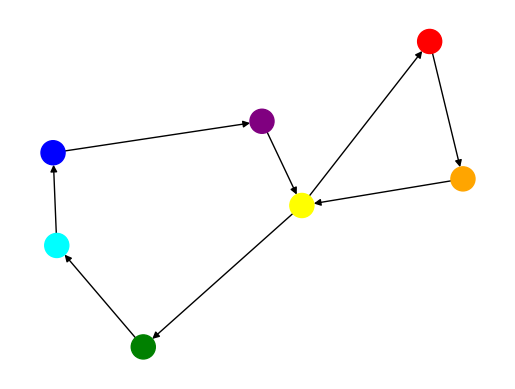

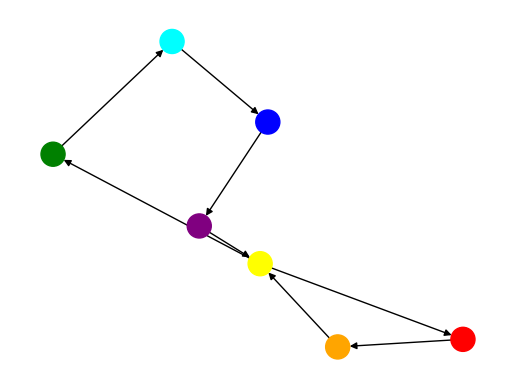

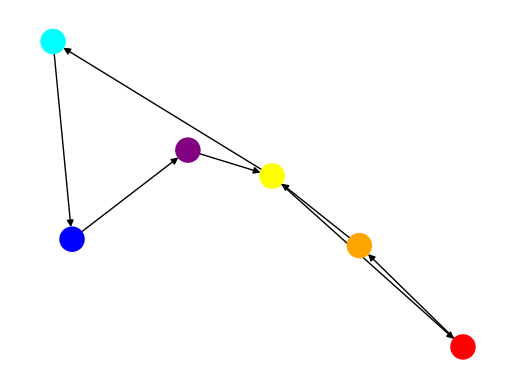

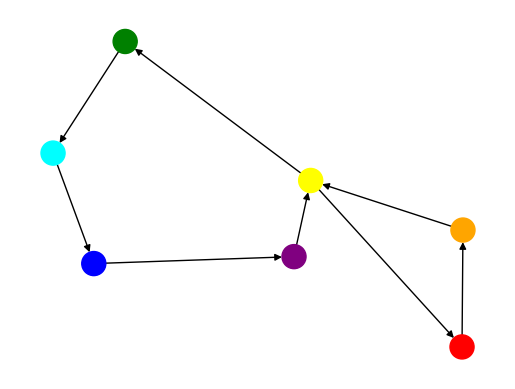

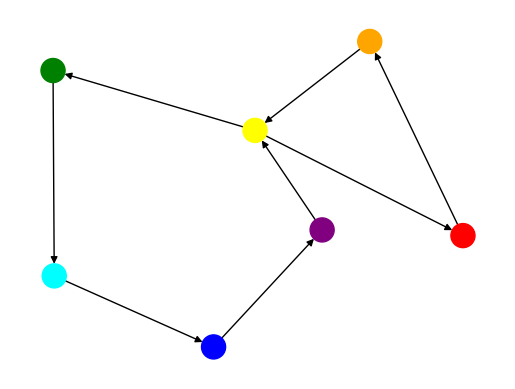

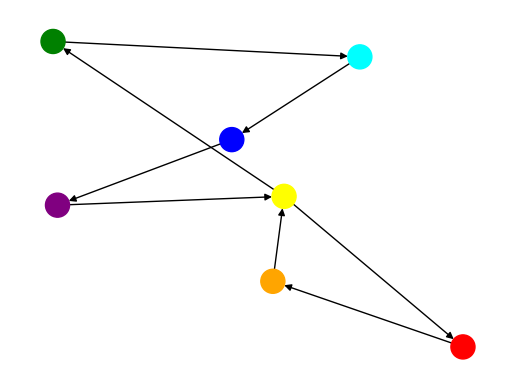

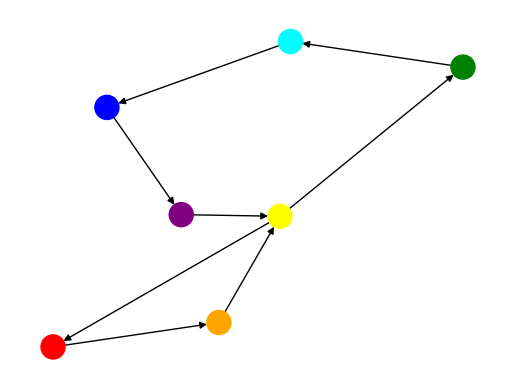

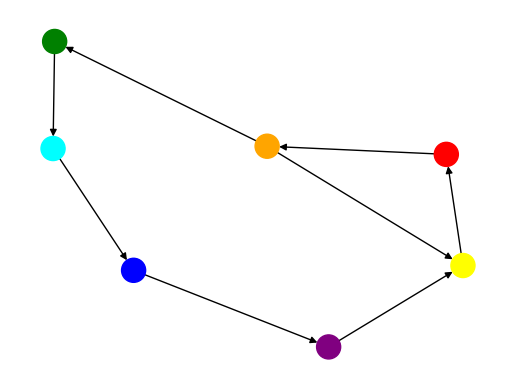

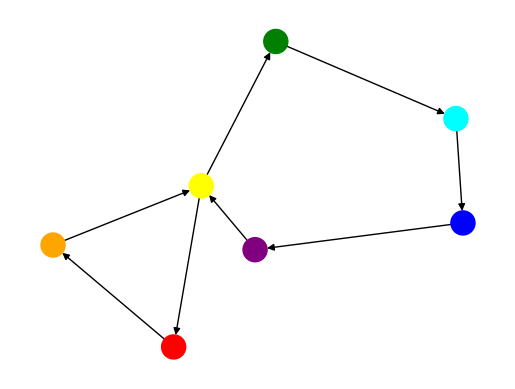

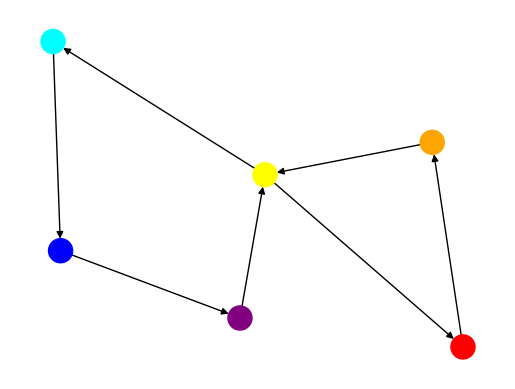

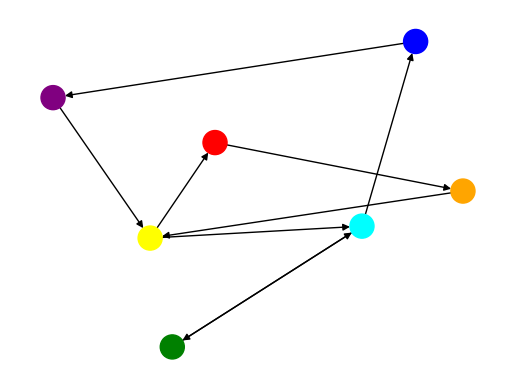

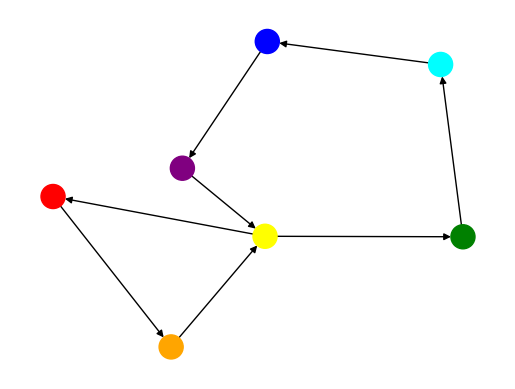

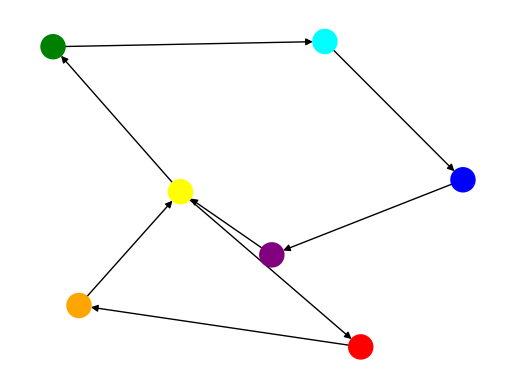

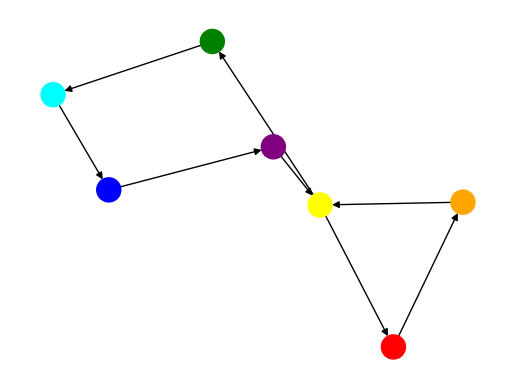

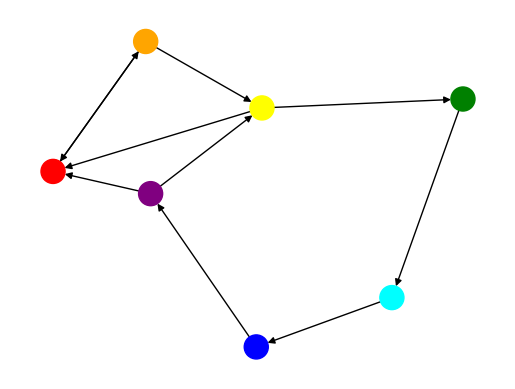

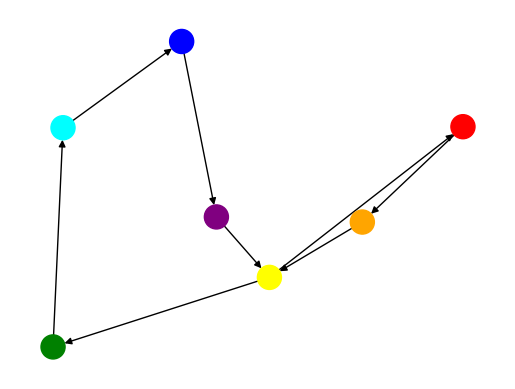

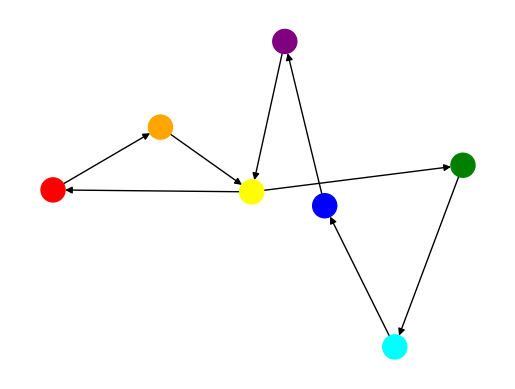

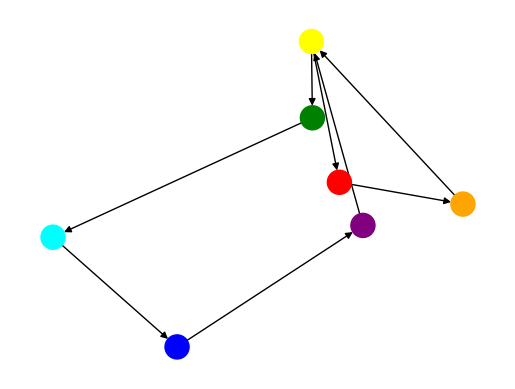

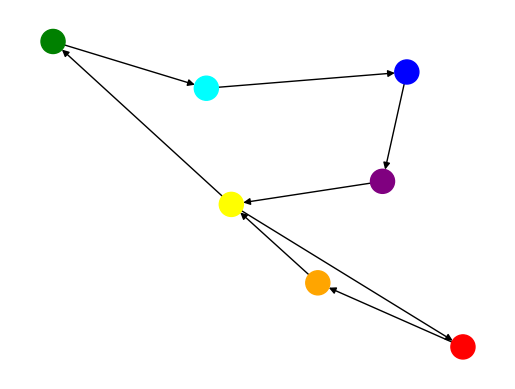

In [7]:
liam_color_dict = {'McKeldin Library':'red', 'Sundial':'orange', 
             'Marie Mount Hall':'yellow', 'Memorial Chapel':'green', 
             'Lee Building':'cyan', 'Reckord Armory':'blue', 
             'Mitchell Building':'purple', 'Other':'black'}
liam_file = "data3/logs_nome_liam.json"
liam_data = setup(liam_file, "datetime")
data_dict.update( liam_data )

for sessID,logs in liam_data.items():
    # Dissect the logs and store them in the sess_elements dictionary
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]
    
    names = sess_elements[sessID]
    # creating the directed graph and assigning the previously defined color-code
    (graph, colors) = get_color_graph(names, liam_color_dict, get_partition)
    f = plt.figure()
    # drawing the di-graph
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    # adding the digraph to our previously defined 'graphs' list.
    graphs[sessID] = (graph, colors)

Washington DC Workflow 3 (madeline's) graphs:

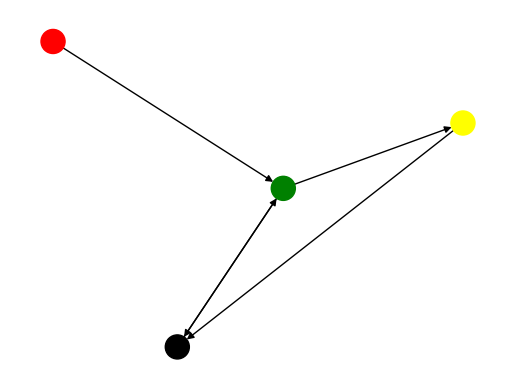

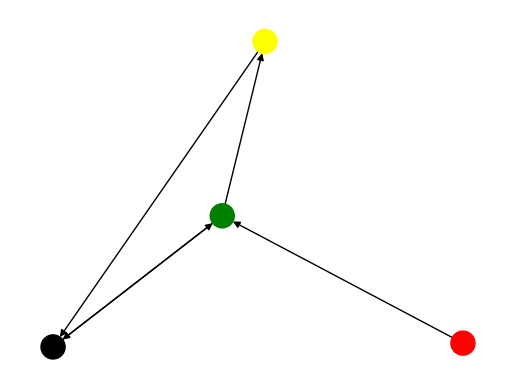

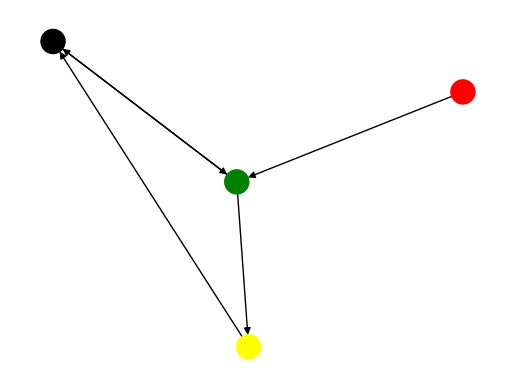

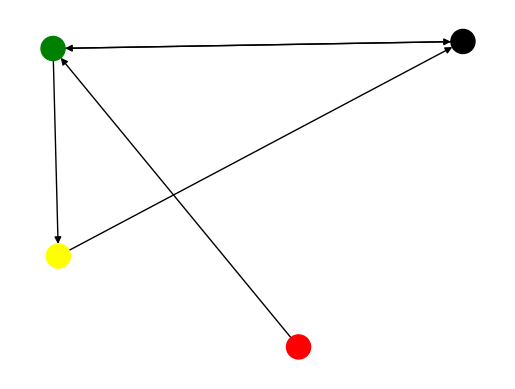

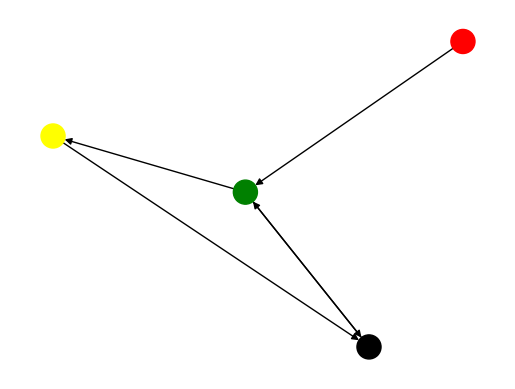

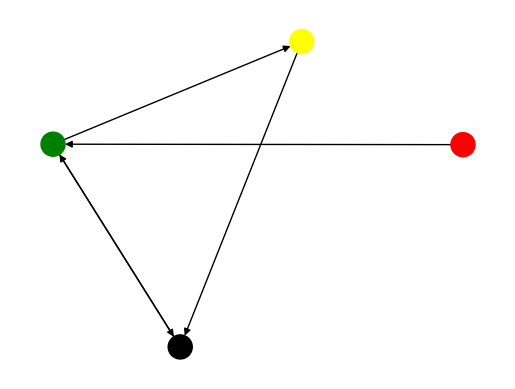

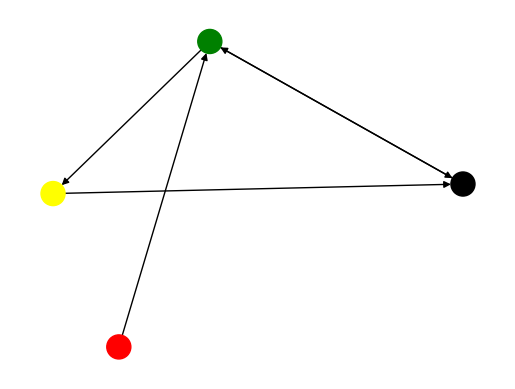

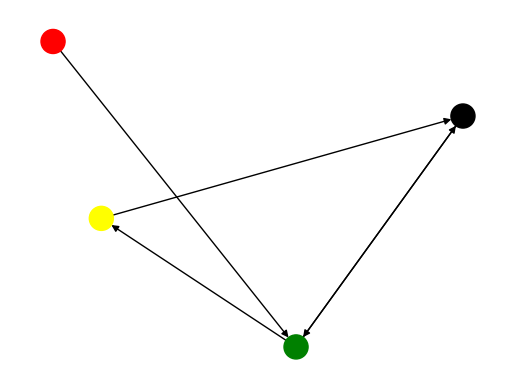

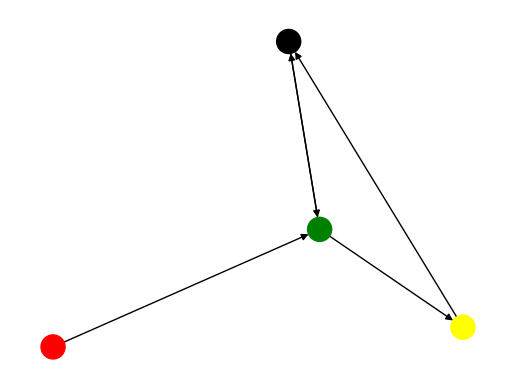

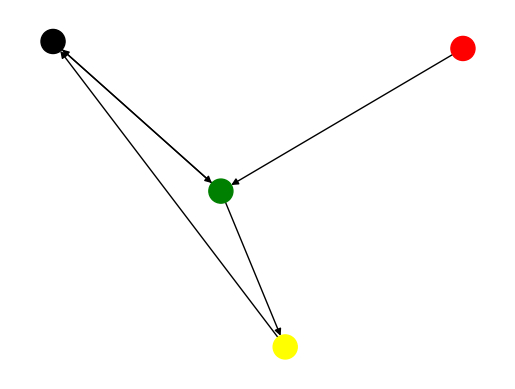

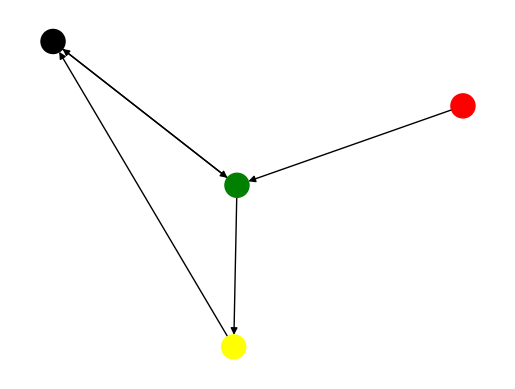

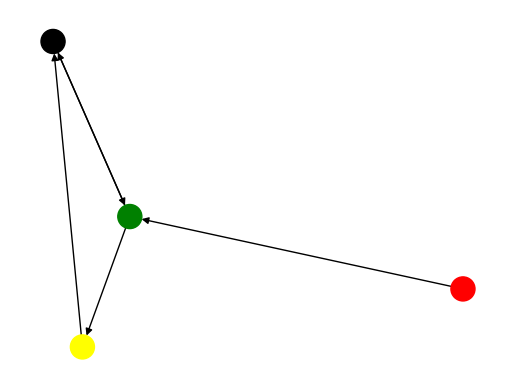

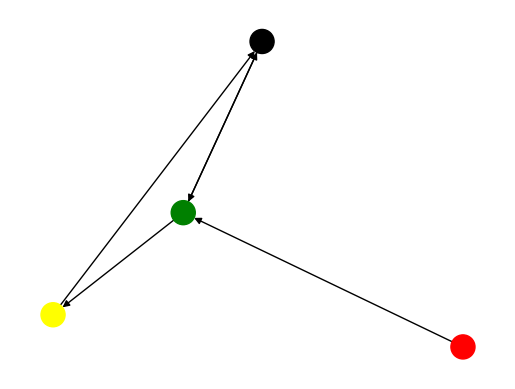

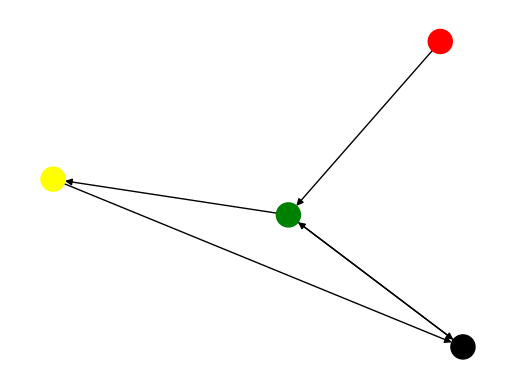

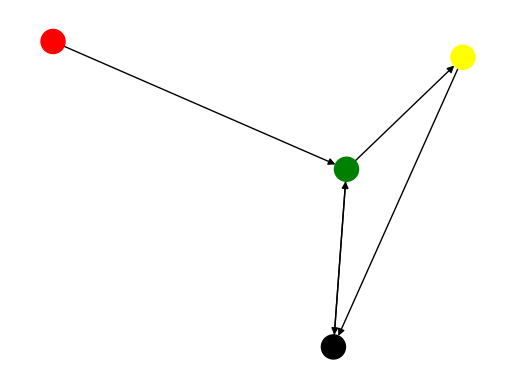

In [8]:
madeline_color_dict = {'Washington Memorial Driveway Southwest':'red', 
             'National Museum of African American History and Culture':'orange', 
             'Holocaust Memorial Museum':'yellow', 
             'National Museum of African American History and Culture':'green', 
             'Other':'black'}

madeline_files = [path for path in all_paths if "madeline" in path]

# Assembling data into a dictionary from each file
madeline_data = {}
for file in madeline_files:
    if len(madeline_data) == 0:
        madeline_data = setup(file, "datetime")
    else:
        madeline_data.update( setup(file, "datetime") )

data_dict.update( madeline_data )
        
for sessID,logs in madeline_data.items():
    # Dissect the logs and store them in the sess_elements dictionary
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]
    
    names = sess_elements[sessID]
    # creating the directed graph and assigning the previously defined color-code
    (graph, colors) = get_color_graph(names, madeline_color_dict, get_partition)
    f = plt.figure()
    # drawing the di-graph
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    # adding the digraph to our previously defined 'graphs' list.
    graphs[sessID] = (graph, colors)

ARLIS Workflow 1 (jason's) graphs:

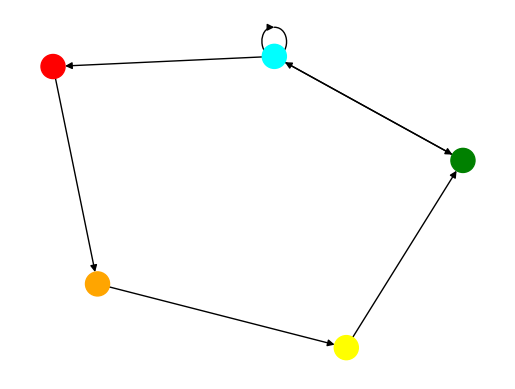

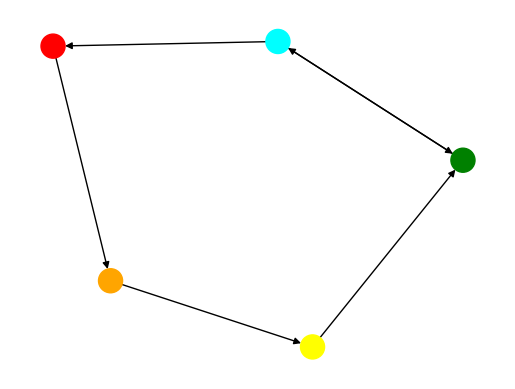

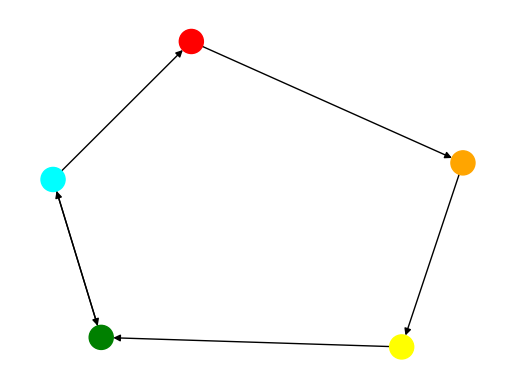

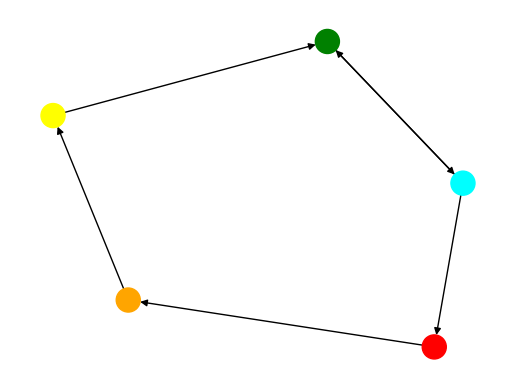

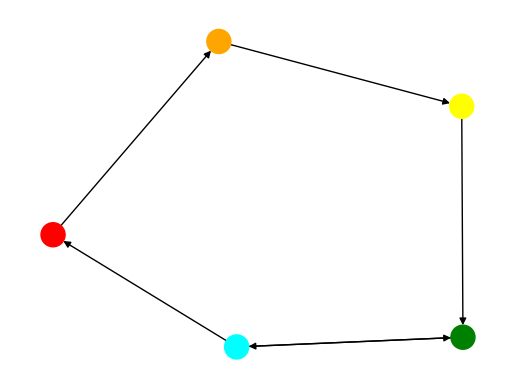

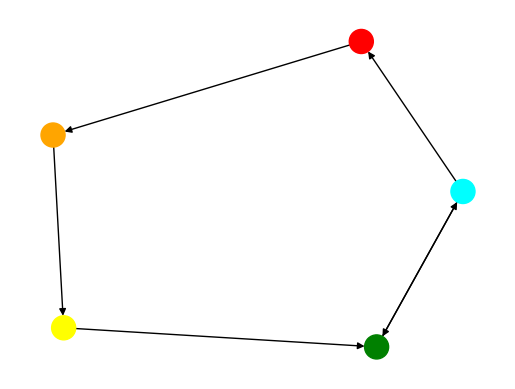

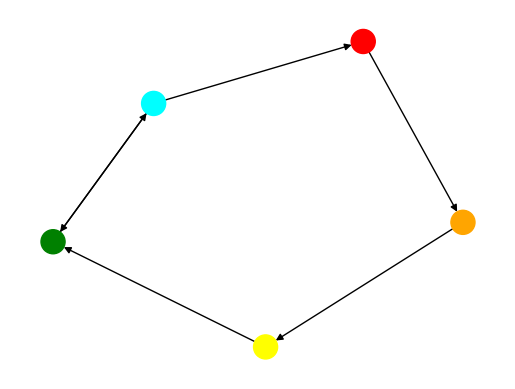

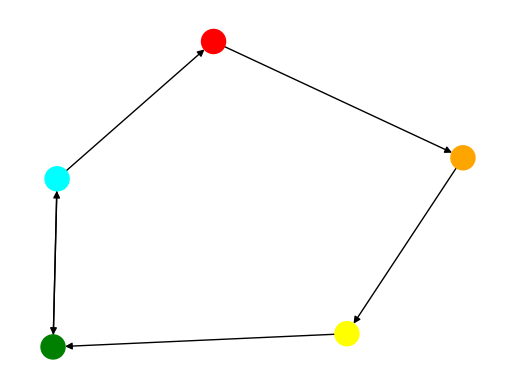

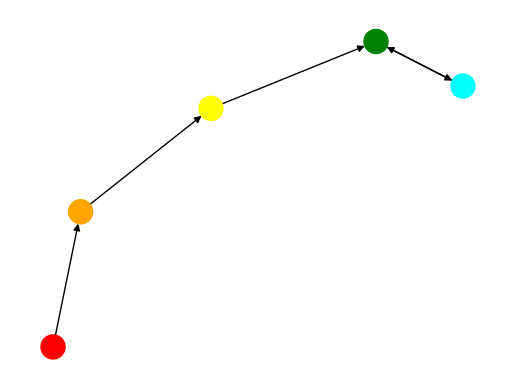

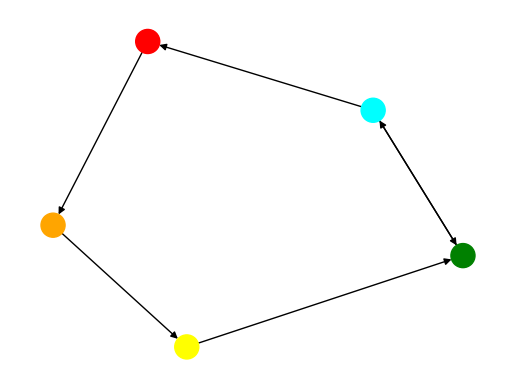

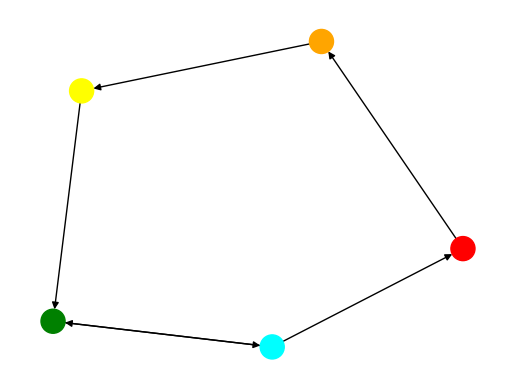

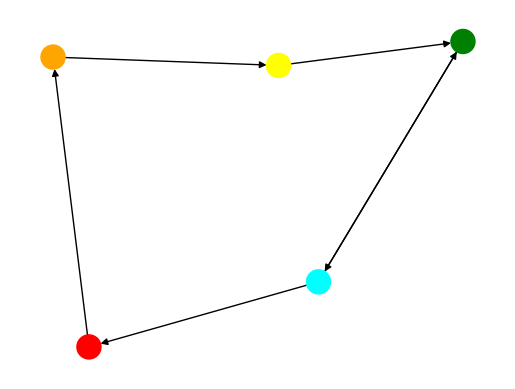

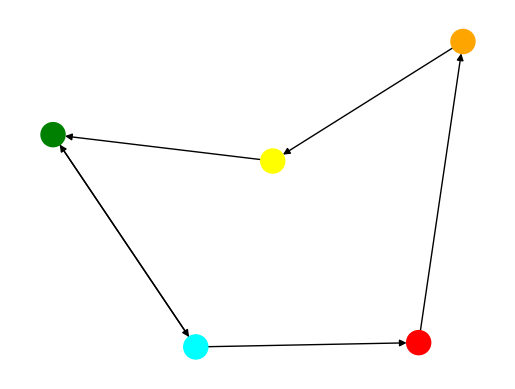

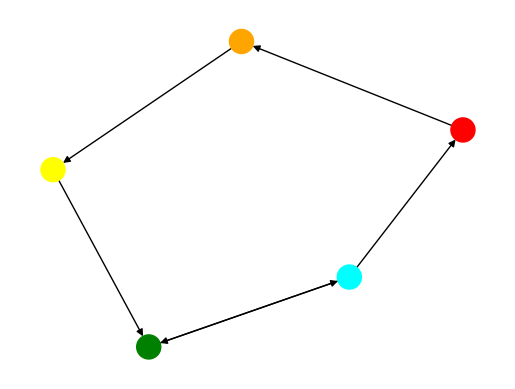

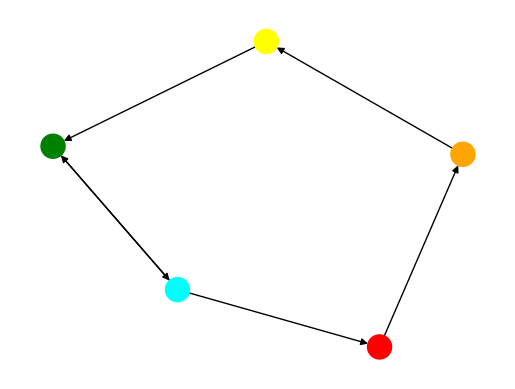

In [9]:
jason_color_dict = {'FDA Annex':'red', 'UM Patapsco Building':'orange', 
             'The Tennis Center At College Park':'yellow', 'Herbert Wells Ice Rink':'green', 
             'UM Center for the Advanced Study of Language':'cyan', 'Other':'black'}

jason_files = [path for path in all_paths if "jason" in path]

# Assembling data into a dictionary from each file
jason_data = {}
for file in jason_files:
    if len(madeline_data) == 0:
        jason_data = setup(file, "datetime")
    else:
        jason_data.update( setup(file, "datetime") )

data_dict.update( jason_data )
        
for sessID,logs in jason_data.items():
    # Dissect the logs and store them in the sess_elements dictionary
    for logID,log in logs.items():
        elem_name = log['details']['name']
        if (not sessID in sess_elements.keys()):
            sess_elements[sessID] = [ elem_name ]
        else:
            sess_elements[sessID] += [ elem_name ]
    
    names = sess_elements[sessID]
    # creating the directed graph and assigning the previously defined color-code
    (graph, colors) = get_color_graph(names, jason_color_dict, get_partition)
    f = plt.figure()
    # drawing the di-graph
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    # adding the digraph to our previously defined 'graphs' list.
    graphs[sessID] = (graph, colors)

## Sequence Data Preprocessing

In [10]:
def generate_sublists(input_list):
    output_list = []
    n = len(input_list)

    for i in range(n):
        for j in range(i + 1, n + 1):
            sublist = input_list[i:j]
            if len(sublist) > 1:
                output_list.append(sublist)

    return output_list

input_list = [1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5]
# input_list = sess_elements['session_1688066755015']
result = generate_sublists(input_list)
# print(result)
print(len(result))


66


## Partitioning

Much like in Prototype_2, we're just going to partition the full input sequence apart from its last element for the purposes of predicting that last element. This is so we can focus on an incremental prediction approach with higher accuracy that will be described later in the "N-Many" section of this notebook

In [11]:
import pandas as pd

# The smallest workflow we have is size 6, so anything less than that gets cut
print("Original # of tasks/sessions: ", len(data_dict))
data = [sess_elements[sessID] for sessID in sess_elements.keys() if len(sess_elements[sessID]) > 5]
print("Refined # of tasks/sessions: ", len(data))

s = set()
for sess_lst in data:
    s.update(sess_lst)
vocab = list(s)
vocab += ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
print(vocab)

# Consider reducing the size of data to only have unique workflow lists, too.
# This would greatly reduce the number of repeated lists
all_data = []
for sess_lst in data:
    all_data += generate_sublists(sess_lst)
print(len(all_data))

Original # of tasks/sessions:  71
Refined # of tasks/sessions:  71
['UM Patapsco Building', 'Herbert Wells Ice Rink', 'USS Constellation', 'Sundial', 'Marie Mount Hall', 'Reckord Armory', 'National Aquarium', 'World Trade Center', 'The Tennis Center At College Park', 'Memorial Chapel', 'FDA Annex', 'National Museum of Natural History', 'National Museum of African American History and Culture', 'UM Center for the Advanced Study of Language', 'Holocaust Memorial Museum', 'USCGC Taney', 'McKeldin Library', 'Maryland Science Center and Planetarium', 'Lee Building', 'Mitchell Building', 'Washington Memorial Driveway Southwest', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']
4121


In [12]:
# Using a specific n value:
# n = 4
# inputs = [s[:-n] for s in data], targets = [s[-n:] for s in data]
# data_tups = [(s[:-n], s[-n:]) for s in data]

# Spliting the list:
data_tups = [(s[:-1], s[-1]) for s in all_data]
# print("data: ", data_tups)
df = pd.DataFrame(data_tups, columns=["inputs", "targets"])
df.head()

,inputs,targets
0,[Maryland Science Center and Planetarium],USS Constellation
1,"[Maryland Science Center and Planetarium, USS ...",World Trade Center
2,"[Maryland Science Center and Planetarium, USS ...",National Aquarium
3,"[Maryland Science Center and Planetarium, USS ...",USCGC Taney
4,"[Maryland Science Center and Planetarium, USS ...",USS Constellation


In [13]:
first_row = df.iloc[4]
print(first_row['inputs'])
print(first_row['targets'])

['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney']
USS Constellation


## **Model** (Training and Evaluation)

**Working LSTM model:**

Bi-directional LSTM that works:

In [21]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

class BiLSTM(nn.Module):
    def __init__(self, vocab):
        super(BiLSTM, self).__init__()
        self.input_size = len(vocab)
        self.hidden_size = len(vocab) 
        self.output_size = len(vocab)
        self.bidirectional = True  # Set bidirectional to True
        self.num_directions = 2 if self.bidirectional else 1

        # Use bidirectional LSTM
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, bidirectional=self.bidirectional)
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        # Adjust the linear layer's input size to account for the concatenated outputs
        self.fc = nn.Linear(self.hidden_size * self.num_directions, self.output_size)
        self.dropout = nn.Dropout(p=0.5)
        
        self.vocab = vocab
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i: w for i, w in enumerate(vocab)}

    def forward(self, input_seq):
        hidden = (torch.zeros(self.num_directions, 1, self.hidden_size),
                  torch.zeros(self.num_directions, 1, self.hidden_size))
        # Convert input sequence to tensor of indices
        input_idx = [self.word2idx[w] for w in input_seq]
        input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)
        
        input_embedded = self.dropout(self.embedding(input_tensor))
        lstm_out, hidden = self.lstm(input_embedded, hidden)

        # Concatenate the forward and backward outputs along the feature dimension
        lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_size], lstm_out[:, 0, self.hidden_size:]), dim=1)
        output = self.fc(lstm_out.view(len(input_seq), -1))
        return output
    
    def pred_next(self, i):
        self.zero_grad()
        output = self(i)
        # Use argmax to find the index with the highest probability
        predicted_idx = torch.argmax(output[-1], dim=-1)
        predicted_word = self.idx2word[predicted_idx.item()]
        return output[-1].unsqueeze(0), predicted_idx, predicted_word
    
    def generate_sequence(self, initial_input, n):
        output_sequence = []

        # Initialize hidden state and cell state
        hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        curr_input = initial_input
        for i in range(n):
            # Predict the next word given the current input sequence
            raw_output, predicted_idx, predicted_word = self.pred_next(curr_input)
            output_sequence.append(predicted_word)
            # Update the input for the next iteration
            curr_input = curr_input[1:] + [predicted_word]

        return output_sequence
    
    def get_prediction_confidence(self, output):
        """Return the model's average confidence level for the given output."""
        softmax_probs = nn.Softmax(dim=1)(output)
        max_probs, _ = torch.max(softmax_probs, dim=1)
        return max_probs.mean().item()

vocab = ['Lee Building', 'World Trade Center', 'Marie Mount Hall', 
         'McKeldin Library', 'Mitchell Building', 'National Museum of Natural History', 
         'Reckord Armory', 'USS Constellation', 'National Museum of African American History and Culture', 
         'Holocaust Memorial Museum', 'UM Center for the Advanced Study of Language', 
         'UM Patapsco Building', 'Memorial Chapel', 'USCGC Taney', 'Sundial', 
         'Herbert Wells Ice Rink', 'FDA Annex', 'National Aquarium', 
         'Maryland Science Center and Planetarium', 'Washington Memorial Driveway Southwest', 
         'The Tennis Center At College Park', 'Pratt Street Pavilion', 
         'Light Street Pavilion', 'Chesapeake']


Training a single model

In [ ]:
# Schuffle and split data 80/20 training/testing with the last kth "fold"
random.shuffle(data_tups)
k = 5
subset_size = len(data_tups) // k
data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]
val_data = data_subsets[ (k-1) ]
train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != (k-1)]

# Define the model
lstm = BiLSTM(vocab=vocab)  # reduced model complexity
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), weight_decay=1e-5)  # L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')  # learning rate scheduler

best_val_loss = float('inf')
best_val_data = val_data

for epoch in range(501):
    for i, t in train_data:
        raw_output, _, _ = lstm.pred_next(i)
        target_idx = torch.tensor([lstm.word2idx[t]], dtype=torch.long)
        loss = loss_fn(raw_output.unsqueeze(0), target_idx)
        loss.backward()
        optimizer.step()

    # Evaluate on validation data every epoch
    val_loss = 0
    with torch.no_grad():
        for i, t in val_data:
            raw_output, _, _ = lstm.pred_next(i)
            target_idx = torch.tensor([lstm.word2idx[t]], dtype=torch.long)
            loss = loss_fn(raw_output.unsqueeze(0), target_idx)
            val_loss += loss.item()

    val_loss /= len(val_data)
#     print(f"Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_data = val_data
        print(f"Best epoch so far: {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
#         torch.save(lstm, 'model_5.pth')

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

Attempting the same as before, but **now with k-fold validation to get the best trained model:**

In [16]:
import random
import sys

# Shuffle data tuples
random.shuffle(data_tups)

# Define the number of folds
k = 5
# Divide data tuples into k subsets of equal size
subset_size = len(data_tups) // k
data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]

best_train_data = []
best_val_data = []
best_lstm = BiLSTM(vocab=vocab)
best_val_loss = float('inf')
# Train and validate model on each subset
for fold in range(k):
    # Define the model
    lstm = BiLSTM(vocab=vocab)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), weight_decay=1e-5)  # L2 regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')  # learning rate scheduler

    # Get the training and validation data for this fold
    val_data = data_subsets[fold]
    train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != fold]

    # Train the model on the training data
    for epoch in range(251):
        for i, t in train_data:
            raw_output, _, _ = lstm.pred_next(i)
            target_idx = torch.tensor([lstm.word2idx[t]], dtype=torch.long)  # Correct target shape
            loss = loss_fn(raw_output, target_idx)  # raw_output is [1, num_classes], target_idx is [1]
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()  # Clear gradients after each step

        # Evaluate on validation data every epoch
        val_loss = 0
        with torch.no_grad():
            for i, t in val_data:
                raw_output, _, _ = lstm.pred_next(i)
                target_idx = torch.tensor([lstm.word2idx[t]], dtype=torch.long)
                loss = loss_fn(raw_output, target_idx)
                val_loss += loss.item()
        val_loss /= len(val_data)
        
        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_lstm = lstm
            best_val_data = val_data
            best_train_data = train_data
            print(f"Best fold so far: {fold} on epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")

# torch.save(best_lstm, 'model_5.pth')

Best fold so far: 0 on epoch 0, Training Loss: 1.449920892715454, Validation Loss: 0.6331523806438781
Best fold so far: 0 on epoch 1, Training Loss: 2.1355843544006348, Validation Loss: 0.5216837806538289
Best fold so far: 0 on epoch 2, Training Loss: 2.111302614212036, Validation Loss: 0.4802981932426846
Best fold so far: 0 on epoch 3, Training Loss: 1.5892314910888672, Validation Loss: 0.46016264977656074
Best fold so far: 0 on epoch 4, Training Loss: 2.0053811073303223, Validation Loss: 0.44323303487131516
Best fold so far: 0 on epoch 5, Training Loss: 1.6299188137054443, Validation Loss: 0.4325066428116933
Best fold so far: 0 on epoch 7, Training Loss: 0.7898536920547485, Validation Loss: 0.4114108739405858
Best fold so far: 0 on epoch 8, Training Loss: 1.6137241125106812, Validation Loss: 0.39747495313420395
Best fold so far: 0 on epoch 11, Training Loss: 0.7099700570106506, Validation Loss: 0.39474978176841946
Best fold so far: 0 on epoch 13, Training Loss: 0.7416065335273743, Va

In [31]:
# torch.save(best_lstm, 'model_5.pth')
torch.save(best_lstm.state_dict(), 'model_5_dict.pth')

## Model Performance

*In case of ingesting a model without running the code above:*

In [22]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

class BiLSTM(nn.Module):
    def __init__(self, vocab):
        super(BiLSTM, self).__init__()
        self.input_size = len(vocab)
        self.hidden_size = len(vocab) 
        self.output_size = len(vocab)
        self.bidirectional = True  # Set bidirectional to True
        self.num_directions = 2 if self.bidirectional else 1

        # Use bidirectional LSTM
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, bidirectional=self.bidirectional)
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        # Adjust the linear layer's input size to account for the concatenated outputs
        self.fc = nn.Linear(self.hidden_size * self.num_directions, self.output_size)
        self.dropout = nn.Dropout(p=0.5)
        
        self.vocab = vocab
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i: w for i, w in enumerate(vocab)}

    def forward(self, input_seq):
        hidden = (torch.zeros(self.num_directions, 1, self.hidden_size),
                  torch.zeros(self.num_directions, 1, self.hidden_size))
        # Convert input sequence to tensor of indices
        input_idx = [self.word2idx[w] for w in input_seq]
        input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)
        
        input_embedded = self.dropout(self.embedding(input_tensor))
        lstm_out, hidden = self.lstm(input_embedded, hidden)

        # Concatenate the forward and backward outputs along the feature dimension
        lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_size], lstm_out[:, 0, self.hidden_size:]), dim=1)
        output = self.fc(lstm_out.view(len(input_seq), -1))
        return output
    
    def pred_next(self, i):
        self.zero_grad()
        output = self(i)
        # Use argmax to find the index with the highest probability
        predicted_idx = torch.argmax(output[-1], dim=-1)
        predicted_word = self.idx2word[predicted_idx.item()]
        return output[-1], predicted_idx, predicted_word
    
    def generate_sequence(self, initial_input, n):
        output_sequence = []

        # Initialize hidden state and cell state
        hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        curr_input = initial_input
        for i in range(n):
            # Predict the next word given the current input sequence
            _, _, predicted_word = self.pred_next(curr_input)
            output_sequence.append(predicted_word)
            # Update the input for the next iteration
            curr_input = curr_input[1:] + [predicted_word]

        return output_sequence
    
    def get_prediction_confidence(self, output):
        """Return the model's average confidence level for the given output."""
        softmax_probs = nn.Softmax(dim=1)(output)
        max_probs, _ = torch.max(softmax_probs, dim=1)
        return max_probs.mean().item()

vocab = ['Lee Building', 'World Trade Center', 'Marie Mount Hall', 
         'McKeldin Library', 'Mitchell Building', 'National Museum of Natural History', 
         'Reckord Armory', 'USS Constellation', 'National Museum of African American History and Culture', 
         'Holocaust Memorial Museum', 'UM Center for the Advanced Study of Language', 
         'UM Patapsco Building', 'Memorial Chapel', 'USCGC Taney', 'Sundial', 
         'Herbert Wells Ice Rink', 'FDA Annex', 'National Aquarium', 
         'Maryland Science Center and Planetarium', 'Washington Memorial Driveway Southwest', 
         'The Tennis Center At College Park', 'Pratt Street Pavilion', 
         'Light Street Pavilion', 'Chesapeake']

In [18]:
import torch

# Create a new instance of the model class
best_lstm = BiLSTM(vocab=vocab)

# Load the saved state_dict
best_lstm.load_state_dict(torch.load('model_5_dict.pth'))

# Schuffle and split data 80/20 training/testing with the last kth "fold"
# random.shuffle(data_tups)
# k = 5
# subset_size = len(data_tups) // k
# data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]
# best_val_data = data_subsets[ (k-1) ]

print("Size of the validation set for our confusion matrix: ", len(best_val_data))

Size of the validation set for our confusion matrix:  824


Attempted to make a confusion matrix, but output can't be modelled as such when there's so many possibilties of multi-dimensional outputs.

In the following confusion matrix, we are displaying where the validation set's true labels intersect/diverge from the model's predictions. More shaded boxes and values **on the diagonal** means the model is making the **correct predictions**. More shaded boxes and values **anywhere else** means the **model is confused** with some of the validation set's inputs on what the right prediction should be.

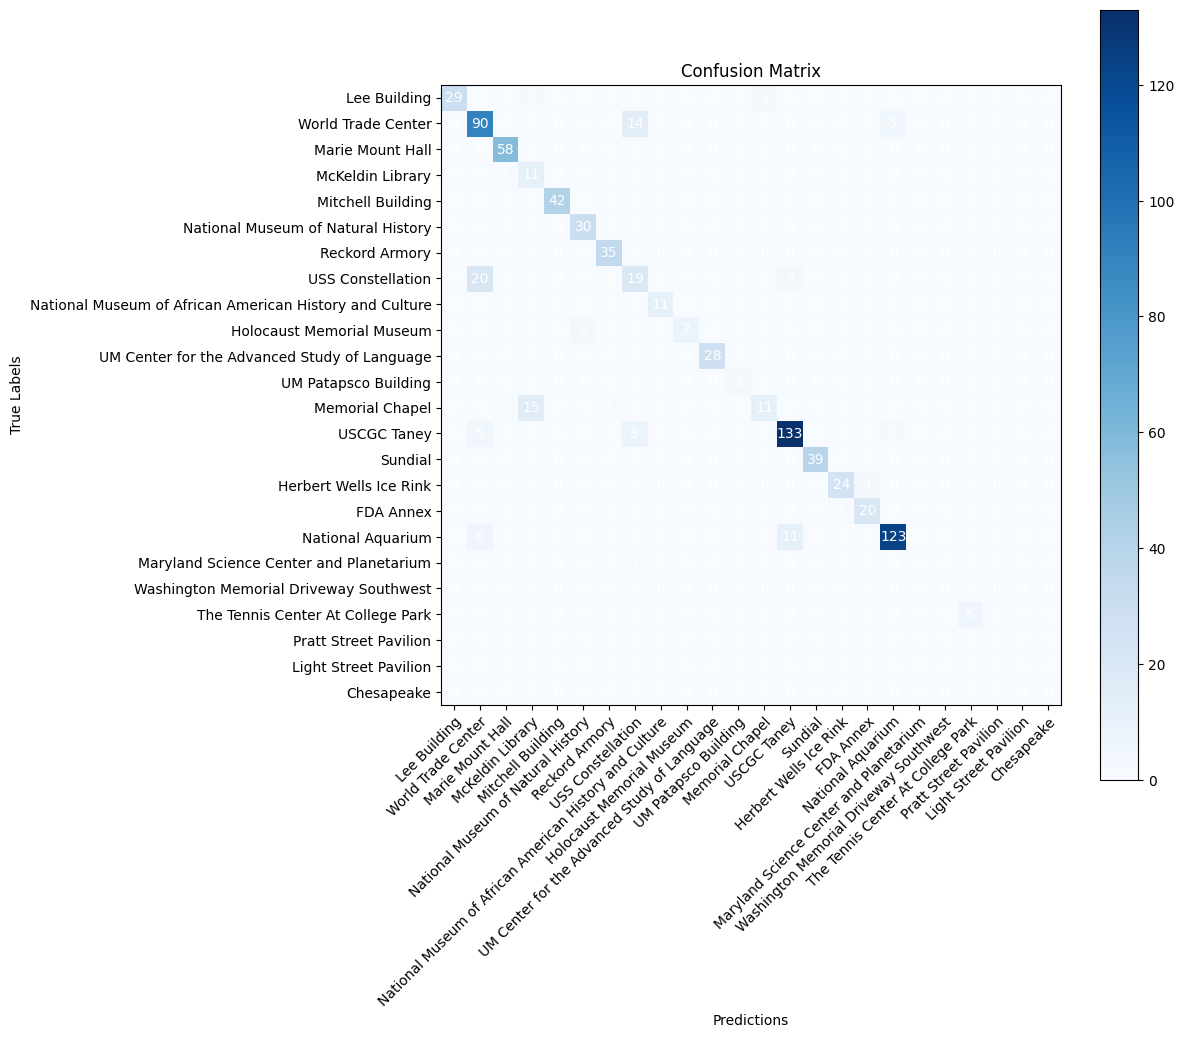

In [41]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
best_lstm.eval()

# Create variables to store predictions and ground truth labels
predictions = []
labels = []
# Loop through the test dataset and make predictions
for i, t in best_val_data:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_label = best_lstm.idx2word[predicted_idx]
    label = t
    predictions.append(predicted_label)
    labels.append(label)

conf_mat = confusion_matrix(labels, predictions, labels=vocab)
# Print the confusion matrix
# print(np.array2string(conf_mat, separator=', '))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(conf_mat, cmap='Blues')

# Set ticks for x and y axis
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(vocab)))

# Set labels for x and y axis
ax.set_xlabel('Predictions')
ax.set_ylabel('True Labels')
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)

# Rotate the x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over the data and create annotations for each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")

# Set title and colorbar
ax.set_title("Confusion Matrix")
fig.colorbar(im)
plt.show()

Now we calculate the average confidence interval across this validation set:

In [25]:
avg_val_confidence = 0
with torch.no_grad():
    for i,t in best_val_data:
        output = best_lstm(i)
        confidence = best_lstm.get_prediction_confidence(output)
        avg_val_confidence += confidence  # Sum up the confidence levels

avg_val_confidence /= len(best_val_data)  # Get average confidence for validation data
print(f"Average Validation Confidence: {avg_val_confidence}")  # Optionally print

Average Validation Confidence: 0.8589761098756373


This confidence score is great! Now, let's look at some specific expected model targets for their respective inputs:

In [26]:
# Test the model on a new input sequence
# ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium']
input_seqs = [['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], 
              ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall'],
              ['Washington Memorial Driveway Southwest', 'National Museum of African American History and Culture', 'Holocaust Memorial Museum'],
              ['FDA Annex', 'UM Patapsco Building', 'The Tennis Center At College Park', 'Herbert Wells Ice Rink']]

for i in input_seqs:
    _, _, predicted_word = best_lstm.pred_next(i)
    print(f'\nInput sequence: {i}, \nPredicted next word: {predicted_word}')
# Should be 'World Trade Center'
# Should be 'Memorial Chapel'
# Should be 'National Museum of Natural History'
# Should be 'UM Center for the Advanced Study of Language'


Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], 
Predicted next word: World Trade Center

Input sequence: ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall'], 
Predicted next word: Memorial Chapel

Input sequence: ['Washington Memorial Driveway Southwest', 'National Museum of African American History and Culture', 'Holocaust Memorial Museum'], 
Predicted next word: National Museum of Natural History

Input sequence: ['FDA Annex', 'UM Patapsco Building', 'The Tennis Center At College Park', 'Herbert Wells Ice Rink'], 
Predicted next word: UM Center for the Advanced Study of Language


So the expected targets are hit when the model is given the right inputs. But what about other inputs?

In [27]:
input_seqs = [['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], 
              ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], 
              ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], 
              ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake']]
for i in input_seqs:
    _, _, predicted_word = best_lstm.pred_next(i)
    print(f'Input sequence: {i}, Predicted next word: {predicted_word}')
#Should expect: USCGC Taney for all of them, because that's the only output there can be right now

Input sequence: ['Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next word: USCGC Taney
Input sequence: ['USCGC Taney', 'Maryland Science Center and Planetarium', 'World Trade Center', 'National Aquarium'], Predicted next word: USCGC Taney
Input sequence: ['USCGC Taney', 'Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next word: USCGC Taney
Input sequence: ['Pratt Street Pavilion', 'Light Street Pavilion', 'Chesapeake'], Predicted next word: National Aquarium


As expected, when presented with information completely outside the training set, the model will not know what to do. This is a problem with the amount of data we have, not the model

## N-Many Application

The way this prototype diverges from the rest is that it is built to detect patterns in the data of any length and will use that information to predict the next "n-many" elements the user might interact with.

The following method outputs a sequence of "n"-many predictions when given an input of our vocabulary's strings. It works by: 

(1) predicting the next string, given the original input sequence, 

(2) making a new input by dropping the first element of the last input and appending the string predicted in part (1) to form a new input, 

(3) predicting the next string, given the new input sequence made by part (2), appending it to an output list starting with the prediction from part (1), and

(4) repeating parts (2) and (3) for "n" iterations before returning the output list

In [28]:
# Test the model on a new input sequence
# ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium']
input_seqs = [['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], 
              ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall'],
              ['Washington Memorial Driveway Southwest', 'National Museum of African American History and Culture', 'Holocaust Memorial Museum', 'National Museum of Natural History'],
              ['FDA Annex', 'UM Patapsco Building', 'The Tennis Center At College Park', 'Herbert Wells Ice Rink']]

n_predictions = 6
for i in input_seqs:
    n = len(i)
    predicted_sequence = best_lstm.generate_sequence(i, n)
    print(f'\nInput sequence: {i}, \nPredicted next n-many: {predicted_sequence}')
# Should be ['World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']
# Should be ['Memorial Chapel', 'Lee Building', 'Reckord Armory', 'Mitchell Building', 'Marie Mount Hall, (McKeldin/Memorial Chapel)']
# Should be ['National Museum of African American History and Culture', 'National Museum of Natural History', 'National Museum of African American History and Culture', 'National Museum of Natural History']
# Should be ['UM Center for the Advanced Study of Language', ('Herbert Wells Ice Rink'/'FDA Annex'), ... 4 more]


Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation'], 
Predicted next n-many: ['World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney']

Input sequence: ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall'], 
Predicted next n-many: ['Memorial Chapel', 'Lee Building', 'Reckord Armory', 'Mitchell Building', 'Marie Mount Hall', 'McKeldin Library']

Input sequence: ['Washington Memorial Driveway Southwest', 'National Museum of African American History and Culture', 'Holocaust Memorial Museum', 'National Museum of Natural History'], 
Predicted next n-many: ['National Museum of African American History and Culture', 'National Museum of Natural History', 'National Museum of African American History and Culture', 'National Museum of Natural History']

Input sequence: ['FDA Annex', 

As we see, It works!!! Now we just need to convert these words to graphs.


ID:  session_1688066755015
Input sequence: ['Maryland Science Center and Planetarium', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'USS Constellation', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney'], 
Predicted next n-many: ['USCGC Taney', 'USS Constellation', 'World Trade Center', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'USCGC Taney', 'World Trade Center', 'National Aquarium', 'National Aquarium']

ID:  session_1688062135244
Input sequence: ['McKeldin Library', 'Sundial', 'Marie Mount Hall', 'McKeldin Library', 'Sundial', 'Marie Mount Hall', 'Memorial Chapel', 'Lee Building', 'Reckord Armory', 'Mitchell Building', 'Marie Mount Hall'], 
Predicted next n-many: ['McKeldin Library', 'Sundial', 'McKeldin Library', 'Sundial', 'Marie Mount Hall', 'Memorial Chapel', 'Lee Building', 'Reckord Armory', 'Mitchell Building', 'Marie Mo

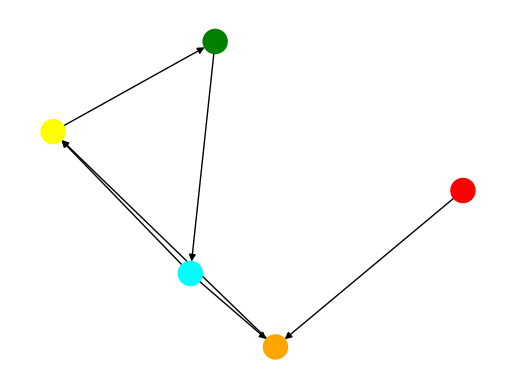

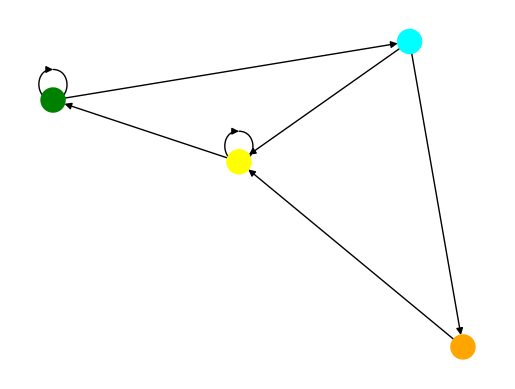

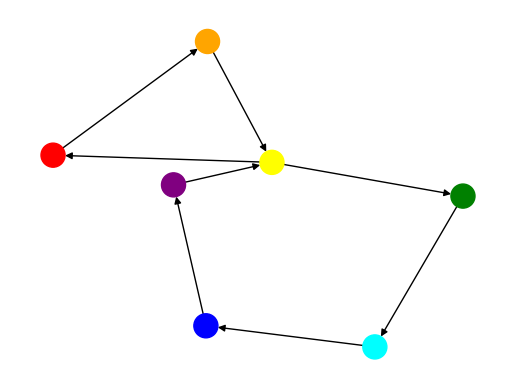

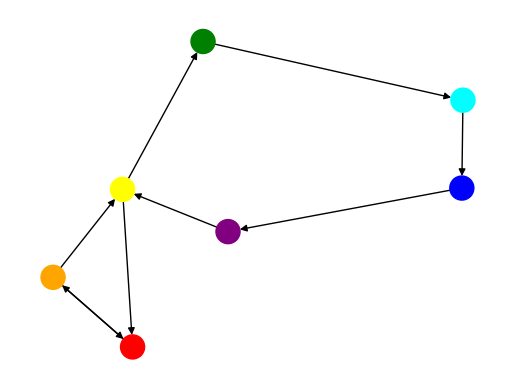

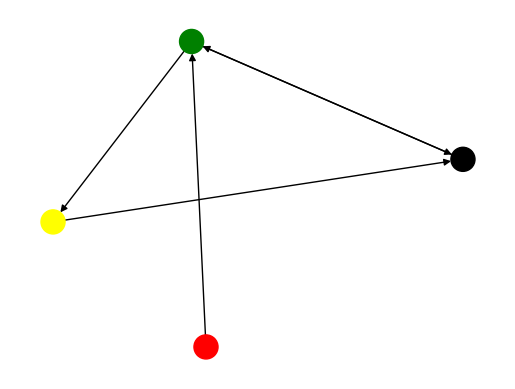

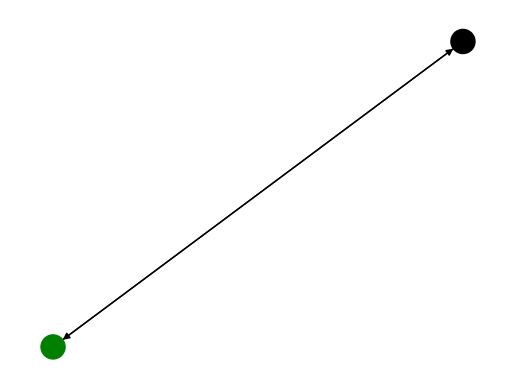

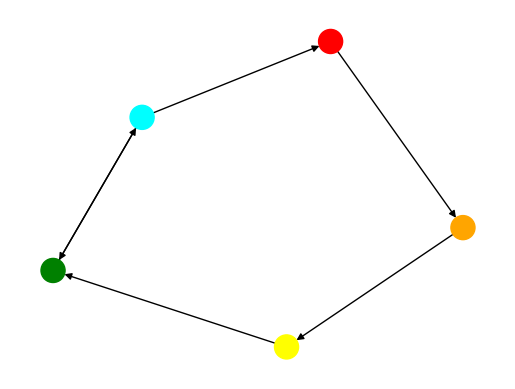

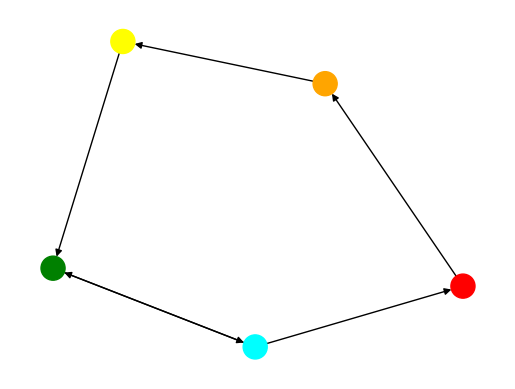

In [29]:
sessions = [("session_1688066755015", vlad_color_dict), 
            ("session_1688062135244", liam_color_dict), 
            ("session_1688051805065", madeline_color_dict),
            ("session_1690308904302", jason_color_dict)]
    
for sessID,color_dict in sessions:
    print("\nID: ", sessID)
    #Original session
    f = plt.figure()
    (graph, colors) = graphs[sessID]
    nx.draw(graph, pos=nx.spring_layout(graph), node_color=colors, ax=f.add_subplot(111))
    
    input_seq = sess_elements[sessID]
    n = len(input_seq)
    predicted_sequence = best_lstm.generate_sequence(input_seq, n)
    print(f'Input sequence: {input_seq}, \nPredicted next n-many: {predicted_sequence}')
    
    # Now figure out a way to turn this list of names into a graph like
    # our prior method did for raw logs
    f = plt.figure()
    (predicted_graph, colors) = get_color_graph(predicted_sequence, color_dict, get_partition)
    nx.draw(predicted_graph, pos=nx.spring_layout(predicted_graph), node_color=colors, ax=f.add_subplot(111))

Graphs look pretty good too! Cyclical nature of the workflows is well captured.

## Save to S3 Bucket

Saving

In [39]:
import s3fs
import torch

# Initialize the s3fs instance
fs = s3fs.S3FileSystem(profile='default')
bucket_name = "odni-model-weights"
model_path = os.path.join(os.getcwd(), 'model_5_dict.pth')

# Save the model to S3
with fs.open(f"{bucket_name}/{model_path}", "wb") as f:
    torch.save(best_lstm.state_dict(), f)


Loading

In [40]:
# Load the model from S3
with fs.open(f"{bucket_name}/{model_path}", "rb") as f:
    best_lstm.load_state_dict(torch.load(f))
